In [1]:
!unzip ECG.zip

Archive:  ECG.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
mit_test_data = pd.read_csv("mitbih_test.csv", header=None)
mit_train_data = pd.read_csv("mitbih_train.csv", header=None)
mit_train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print(mit_train_data.info()); print()
print(mit_test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB
None


In [6]:
print('The number of samples for each category in the training set is:')
mit_train_data[187].value_counts()

The number of samples for each category in the training set is:


0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

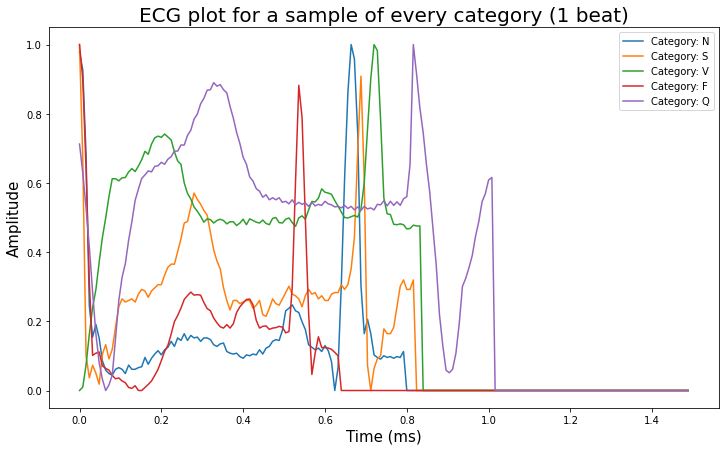

In [7]:
# visualize representative samples of each class
M = mit_train_data.values
X = M[:, :-1]
y = M[:, -1].astype(int)

C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(12,7))
plt.plot(x, X[C0, :][0], label="Category: N")
plt.plot(x, X[C1, :][0], label="Category: S")
plt.plot(x, X[C2, :][0], label="Category: V")
plt.plot(x, X[C3, :][0], label="Category: F")
plt.plot(x, X[C4, :][0], label="Category: Q")
plt.legend()
plt.title("ECG plot for a sample of every category (1 beat)", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

In [40]:
from tensorflow.keras.utils import to_categorical

X = mit_train_data.loc[:, mit_train_data.columns != 187]
y = mit_train_data.loc[:, mit_train_data.columns == 187]
y = to_categorical(y)

X_test = mit_test_data.loc[:, mit_test_data.columns != 187]
y_test = mit_test_data.loc[:, mit_test_data.columns == 187]
y_test = to_categorical(y_test)
ECG_shape=(X.shape[1],1)

X=mit_train_data.iloc[:,:186].values
X_test=mit_test_data.iloc[:,:186].values
X = X.reshape(len(X), X.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [41]:
type(X)

numpy.ndarray

### This is a CNN model that uses 1D convolution to learn the features in the ECG dataset

In [42]:
def my_model(shape):
    # weight and bias initializers
    w = tf.keras.initializers.GlorotUniform(seed=99)
    b = tf.keras.initializers.Zeros()
    # create the CNN model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, (3), activation='relu',
                               bias_initializer=b, kernel_initializer=w, input_shape=shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),
        tf.keras.layers.Conv1D(128, (3), activation='relu',
                               bias_initializer=b, kernel_initializer=w),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),
        tf.keras.layers.Conv1D(256, (3), activation='relu',
                               bias_initializer=b, kernel_initializer=w),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, bias_initializer=b, kernel_initializer=w, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, bias_initializer=b, kernel_initializer=w, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(5, bias_initializer=b, kernel_initializer=w, activation='softmax')
    ], name='ECG_model')
    return model

In [43]:
model = my_model(ECG_shape)
model.summary()

Model: "ECG_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 185, 64)           256       
_________________________________________________________________
batch_normalization_15 (Batc (None, 185, 64)           256       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 92, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 90, 128)           24704     
_________________________________________________________________
batch_normalization_16 (Batc (None, 90, 128)           512       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 45, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 43, 256)           98

In [44]:
from sklearn.model_selection import train_test_split
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.4)

In [45]:
batch_size = 1024
train_samples = X.shape[0]
validation_samples = X_validation.shape[0]
num_epochs = 100

In [46]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.98):
            print("\nReached 98% validation accuracy! stopping training now.")
            self.model.stop_training = True
callbacks = myCallback()

In [47]:
# instantiate the optimizer
optmz = tf.keras.optimizers.Adam()
# compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])
# fit the parameters
history = model.fit(
    X,
    y,
    steps_per_epoch=train_samples//batch_size,
    epochs=num_epochs,
    verbose = 1,
    validation_data = (X_validation, y_validation),
    validation_steps = validation_samples//batch_size,
    callbacks=[callbacks])

Epoch 1/100
85/85 [==============================] - 10s 121ms/step - loss: 0.3334 - accuracy: 0.9110 - val_loss: 5.0121 - val_accuracy: 0.0241
Epoch 2/100
85/85 [==============================] - 10s 114ms/step - loss: 0.1580 - accuracy: 0.9575 - val_loss: 5.8308 - val_accuracy: 0.0676
Epoch 3/100
85/85 [==============================] - 10s 113ms/step - loss: 0.1303 - accuracy: 0.9662 - val_loss: 7.0499 - val_accuracy: 0.0675
Epoch 4/100
85/85 [==============================] - 10s 114ms/step - loss: 0.1081 - accuracy: 0.9709 - val_loss: 2.4411 - val_accuracy: 0.0826
Epoch 5/100
85/85 [==============================] - 10s 114ms/step - loss: 0.0974 - accuracy: 0.9735 - val_loss: 1.2846 - val_accuracy: 0.3624
Epoch 6/100
85/85 [==============================] - 10s 114ms/step - loss: 0.0881 - accuracy: 0.9755 - val_loss: 0.3815 - val_accuracy: 0.8948
Epoch 7/100
85/85 [==============================] - 10s 114ms/step - loss: 0.0783 - accuracy: 0.9781 - val_loss: 0.1430 - val_accuracy:

### Note how quickly the CNN architecture is able to learn the parameters. After 9 epochs, we can already see promising results! Also, using batch normalization for the convolutional layers and dropout for the FC layers, we are able to prevent the model from overfitting the training set. 

Training accuracy after 9 epochs: 0.9806
Testing accuracy after 9 epochs: 0.9820


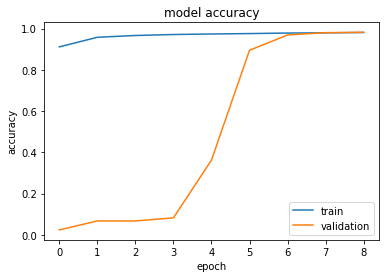

In [49]:
print('Training accuracy after 9 epochs: %.4f'%history.history['accuracy'][-1])
print('Testing accuracy after 9 epochs: %.4f'%history.history['val_accuracy'][-1])
# plot the accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

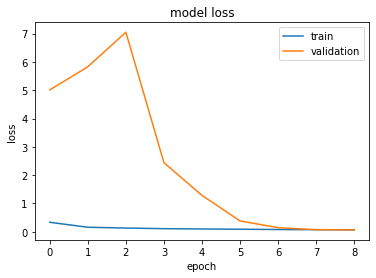

In [51]:
# plot the loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [52]:
print('Let us try to evaluate our model on our test set')
mse, acc = model.evaluate(X_test, y_test)
print('mean_squared_error :', mse)
print('accuracy:', acc)

Let us try to evaluate our model on our test set
274/274 [==============================] - 1s 5ms/step - loss: 0.0751 - accuracy: 0.9820
mean_squared_error : 0.07508746534585953
accuracy: 0.9819573163986206


### Not only does our model generalize to the validation set, it also does well on the test set. By training it for more epochs, we'd expect it to perform even better. 
### To see the advantages of this CNN model, let's try to run a simple fully connected model and compare the results. 

In [58]:
naive_model = tf.keras.models.Sequential(name='naive')
naive_model.add(tf.keras.layers.Flatten()),
naive_model.add(tf.keras.layers.Dense(50, activation='relu'))
naive_model.add(tf.keras.layers.Dense(50, activation='relu'))
naive_model.add(tf.keras.layers.Dense(5, activation='softmax'))

naive_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# fit the parameters
history = naive_model.fit(
    X,
    y,
    steps_per_epoch=train_samples//batch_size,
    epochs=num_epochs,
    verbose = 1,
    validation_data = (X_validation, y_validation),
    validation_steps = validation_samples//batch_size,
    callbacks=[callbacks])

Epoch 1/100
85/85 [==============================] - 1s 7ms/step - loss: 0.8029 - accuracy: 0.7946 - val_loss: 0.4502 - val_accuracy: 0.8786
Epoch 2/100
85/85 [==============================] - 0s 5ms/step - loss: 0.3781 - accuracy: 0.8962 - val_loss: 0.3301 - val_accuracy: 0.9105
Epoch 3/100
85/85 [==============================] - 0s 5ms/step - loss: 0.3041 - accuracy: 0.9171 - val_loss: 0.2827 - val_accuracy: 0.9220
Epoch 4/100
85/85 [==============================] - 0s 5ms/step - loss: 0.2629 - accuracy: 0.9268 - val_loss: 0.2479 - val_accuracy: 0.9293
Epoch 5/100
85/85 [==============================] - 0s 5ms/step - loss: 0.2327 - accuracy: 0.9359 - val_loss: 0.2210 - val_accuracy: 0.9380
Epoch 6/100
85/85 [==============================] - 0s 5ms/step - loss: 0.2113 - accuracy: 0.9423 - val_loss: 0.2032 - val_accuracy: 0.9459
Epoch 7/100
85/85 [==============================] - 0s 5ms/step - loss: 0.1935 - accuracy: 0.9478 - val_loss: 0.1892 - val_accuracy: 0.9502
Epoch 8/100
8

In [60]:
print('Let us try to evaluate our naive model on our test set')
mse, acc = naive_model.evaluate(X_test, y_test)
print('mean_squared_error :', mse)
print('accuracy:', acc)

Let us try to evaluate our naive model on our test set
274/274 [==============================] - 1s 3ms/step - loss: 0.1098 - accuracy: 0.9751
mean_squared_error : 0.10981053113937378
accuracy: 0.9751056432723999


### As we can see, the model does not perform nearly as well